## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Blog-Generator"

# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
# llm=ChatGroq(model="qwen-2.5-32b")

## Defining the tools

#### Arxiv

In [2]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

@traceable
def arxiv_search(query):
    """
        Search for the top 3 results according to the user query using ArxivAPIWrapper.
        The information returned is a list with the top 3 related articles with at least the following information:
        Title
        Published
        Authors
        Summary
        PDF_url
    """

    # Using qwen-2.5-32b limits to 6000 per minute so I set doc_content_chars_max = 5900
    arxiv = ArxivAPIWrapper(
        top_k_results = 1,
        ARXIV_MAX_QUERY_LENGTH = 300,
        load_all_available_meta = True,
        doc_content_chars_max = 500
    )

    # Run Query and Get Results
    # query = "GAN's"
    results = arxiv.load(query)

    for article in results:
        print(f"Title: {article.metadata.get('Title', 'N/A')}")
        print(f"Published: {article.metadata.get('Published', 'N/A')}")
        print(f"Authors: {article.metadata.get('Authors', 'N/A')}\n")
        print(f"Summary: {article.metadata.get('Summary', 'N/A')[:250]}\n")
        print(f"PDF url: {article.metadata.get('entry_id', 'N/A')}\n")
    return results


#### Wikipedia

In [3]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

## Binding the tools

In [4]:
tools=[wiki,arxiv_search]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=True)

## Define the Initial State

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [6]:
# System message
sys_msg = SystemMessage(content=
                        """You are a helpful assistant tasked with creating a blog.
                        Your first commitment is:
                        1. Use the arxiv tool to search for the top 3 articles related to the user's question.

                        2. Give the user the option to use wikipedia in case they want to research a term in the summaries.

                        3. Wait for user's feedback

                        4. If rejected try again from point 1.

                        5. If accepted create a blog with the articles information.
                     
                        """)                      


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Defining the graph

#### First I define a node that will be helpful for the human feedback

In [7]:
# from langgraph.graph import START, StateGraph, END
# def human_feedback(state: MessagesState):
#     """ Return the next node to execute """

#     # Check if human feedback
#     # human_analyst_feedback=state.get('human_analyst_feedback', None)
#     # if human_analyst_feedback:
#     return "tools"
    
#     # Otherwise end
#     return END

In [8]:
from langgraph.graph import START, StateGraph, END

@traceable
def human_feedback(state: MessagesState):
    """ Return the next node to execute """
    
    user_input = state["messages"][-1].content.lower()
    if "yes" in user_input:
        return "tools"
    elif "no" in user_input or "end" in user_input:
        print("🚨 Routing to END (Stopping Execution)")
        return END 
    print("⚠️ Defaulting to END (Shouldn't Happen)")
    return END


In [9]:
@traceable
def custom_condition(state: MessagesState):
    """ Manually decide whether to go to tools or end. """
    decision = human_feedback(state)  # Use the updated function

    if decision == "tools":
        return "tools"
    return END  # Ensure it stops properly

#### Then I define the graph

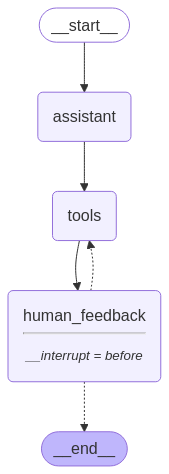

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("human_feedback",human_feedback)
builder.add_node("tools",ToolNode(tools))
# Define edges
builder.add_edge(START,"assistant")
builder.add_edge("assistant","tools")
builder.add_edge("tools","human_feedback")
builder.add_conditional_edges(
    "human_feedback", custom_condition, {"tools": "tools", END: END}
)
# builder.add_conditional_edges(
#     "human_feedback",tools_condition,["tools",END]
# )

#workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})

# Set up memory
memory = MemorySaver()
# Compile the graph with memory
scienceBlogCreator = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

# Show
display(Image(scienceBlogCreator.get_graph().draw_mermaid_png()))

## Using the Agent

#### First call to use the Arxiv tool

#### Invoking the llm

In [11]:
# Input
# user_input=input("What do you want to research about?")
user_input="GANs"
messages = {"messages": HumanMessage(content=user_input)}

thread={"configurable":{"thread_id":"arxiv_call_1"}}
# messages = scienceBlogCreator.invoke({"messages":messages})
# messages={'messages':HumanMessage(content=messages)}
# scienceBlogCreator.stream(messages,thread,stream_mode="values")
for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_pUPecDFYkAICO3AURmzUwQyu)
 Call ID: call_pUPecDFYkAICO3AURmzUwQyu
  Args:
    query: GANs
Title: Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey
Published: 2021-11-26
Authors: Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley

Summary: This is a tutorial and survey paper on Generative Adversarial Network (GAN),
adversarial autoencoders, and their variants. We start with explaining
adversarial learning and the vanilla GAN. Then, we explain the conditional GAN
and DCGAN. The mode col

PDF url: http://arxiv.org/abs/2111.13282v1

================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutor

In [12]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_pUPecDFYkAICO3AURmzUwQyu)
 Call ID: call_pUPecDFYkAICO3AURmzUwQyu
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [13]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [14]:
scienceBlogCreator.get_state(thread).tasks

(PregelTask(id='c4fc986e-3ea1-b93e-6138-e61deac63fe2', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),)

## Human Feedback

#### Update the state asking to the user if they want to research a topic in wikipedia

In [16]:
# user_input=input("Do you want to clarify any term by using Wikipedia?")
user_input="yes, research what is a network in machine learning using wikipedia"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should go to END."""),
        HumanMessage(content=user_input)
    ]},
    #  as_node="human_feedback"
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

yes, research what is a network in machine learning using wikipedia
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_aQTR2QBDxGG7OLFlXT9aZBEw)
 Call ID: call_aQTR2QBDxGG7OLFlXT9aZBEw
  Args:
    query: network in machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks wit


In [17]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_pUPecDFYkAICO3AURmzUwQyu)
 Call ID: call_pUPecDFYkAICO3AURmzUwQyu
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [18]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [20]:
# Input
# user_input=input("Do you want to research another term in wiki?")
user_input="yes, research who created the adversarial architecture"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should go to END."""),
        # HumanMessage(content=f'{{"arguments": {{"query": "{user_input}"}}}}')
        HumanMessage(content=user_input)
    ]},
    #  as_node="human_feedback"
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

yes, research who created the adversarial architecture
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7t5noxfJDFY4w6mtwJaGTxmD)
 Call ID: call_7t5noxfJDFY4w6mtwJaGTxmD
  Args:
    query: adversarial architecture
================================= Tool Message =================================
Name: wikipedia

Page: Generative adversarial network
Summary: A generative adversarial network (GAN) is a class of machine learning frameworks and a prominent framework for approaching generative artificial intelligence. The concept was initially developed by Ian Go


In [21]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [22]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_pUPecDFYkAICO3AURmzUwQyu)
 Call ID: call_pUPecDFYkAICO3AURmzUwQyu
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [23]:
# user_input=input("Do you want to research another term in wiki?")
user_input = "No, I do not want to research another term in wiki"

# Properly structure the Wikipedia tool call
tool_call = {
    "name": "wikipedia",
    "arguments": {"query": f"{user_input}"}
}

# Update state with correctly formatted tool call
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a Wikipedia search or if you should go to END."""),

        # Convert dictionary to JSON string properly
        HumanMessage(content=json.dumps(tool_call))  # ✅ Ensures correct JSON structure
    ]},
    as_node="human_feedback"  # Ensure this node properly processes feedback
)

decision = human_feedback(scienceBlogCreator.get_state(thread).values)
print(f"Decision: {decision}")

scienceBlogCreator.get_state(thread).next
# Stream execution
# for event in scienceBlogCreator.stream(messages, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()

🚨 Routing to END (Stopping Execution)
🚨 Routing to END (Stopping Execution)
Decision: __end__


()

In [25]:
# scienceBlogCreator.get_state(thread).values

In [26]:
# # Continue the graph execution
# for event in scienceBlogCreator.stream(None, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()


In [27]:
# state_after_feedback = scienceBlogCreator.get_state(thread).values
# decision = tools_condition(state_after_feedback)
# print(f"🛠️ tools_condition decision: {decision}")


In [ ]:
# decision = human_feedback(scienceBlogCreator.get_state(thread).values)
# print(f"Decision: {decision}")